# PORTUGUESE BANK MARKETING ON A TERM DEPOSIT - Comparing Machine Learning Classifiers

## GOALS 
- To compare the performance of several machine learning classifiers, specifically K-Nearest Neighbors, Logistic Regression, Decision Trees, and Support Vector Machines, in order to evaluate their effectiveness for the given task.
- To enhance model performance and reliability by applying cross-validation techniques and conducting hyperparameter tuning using GridSearchCV.

## DATA ACQUISITION
<ul>
    <li>SOURCE: UCI Machine Learning repository from a Portuguese Bank institution </li>
    <li>DATA SIZE: There are 41,188 records and 21 features</li>
    <li>The dataset is a collection of the results of 42 marketing campaigns that were based on phone calls. Clients were contacted to inquire their interest in term deposit. Their repsonses of whether they would subscribe or not were recorded.</li>
</ul>

## DATA FEATURES AND DESCRIPTIONS

Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


## DATA UNDERSTANDING

In [6]:
# Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.
raw_data = pd.read_csv('data/bank-additional-full.csv', sep = ';')
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
# Check the number of rows and columns of the raw data
raw_data.shape

(41188, 21)

In [8]:
# Counts the number of campaigns this data represent
raw_data['campaign'].nunique()

42

In [9]:
# Check for missing values
missing_values = raw_data.isna().mean().round(4) * 100
missing_values

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

In [10]:
# Check for duplicates
duplicates = raw_data[raw_data.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 12


In [11]:
# Check details of duplicates including original
raw_data['duplicate_count'] = raw_data.groupby(list(raw_data.columns))[list(raw_data.columns)[0]].transform('count')
duplicates_all = raw_data[raw_data.duplicated(keep=False)].sort_values(by=list(raw_data.columns), kind='mergesort')

print(f"Number of duplicated records (including originals): {duplicates_all.shape[0]}")
duplicates_all

Number of duplicated records (including originals): 24


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duplicate_count
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no,2
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no,2
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,2
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,2
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no,2
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no,2
32505,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,2
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,2
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no,2
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no,2


In [12]:
# Remove duplicates, keep first occurrence
df_nodups = raw_data.drop_duplicates()
print(f"Rows before: {raw_data.shape[0]}, after: {df_nodups.shape[0]}")


Rows before: 41188, after: 41176


#### Removed 12 duplicate records 

In [14]:
# Remove irrelevant columns not used in modeling and renamed y to subscription (status)
bankmktg_df = df_nodups.drop(columns=['duplicate_count', 'contact', 'month', 'day_of_week', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed'])
bankmktg_df = bankmktg_df.rename(columns={"y": "subscription"})
bankmktg_df.head()

,age,job,marital,education,default,housing,loan,duration,campaign,subscription
0,56,housemaid,married,basic.4y,no,no,no,261,1,no
1,57,services,married,high.school,unknown,no,no,149,1,no
2,37,services,married,high.school,no,yes,no,226,1,no
3,40,admin.,married,basic.6y,no,no,no,151,1,no
4,56,services,married,high.school,no,no,yes,307,1,no


In [15]:
 # Look at number of rows/columns, summary statistics and data types (total counts of numberical/categorical)
print("The data has {} rows and {} columns".format(bankmktg_df.shape[0], bankmktg_df.shape[1]))
display(bankmktg_df.describe())
display(bankmktg_df.dtypes.value_counts())

The data has 41176 rows and 10 columns


,age,duration,campaign
count,41176.00000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879
std,10.42068,259.305321,2.770318
min,17.00000,0.000000,1.000000
25%,32.00000,102.000000,1.000000
50%,38.00000,180.000000,2.000000
75%,47.00000,319.000000,3.000000
max,98.00000,4918.000000,56.000000


object    7
int64     3
dtype: int64

In [16]:
bankmktg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           41176 non-null  int64 
 1   job           41176 non-null  object
 2   marital       41176 non-null  object
 3   education     41176 non-null  object
 4   default       41176 non-null  object
 5   housing       41176 non-null  object
 6   loan          41176 non-null  object
 7   duration      41176 non-null  int64 
 8   campaign      41176 non-null  int64 
 9   subscription  41176 non-null  object
dtypes: int64(3), object(7)
memory usage: 3.5+ MB


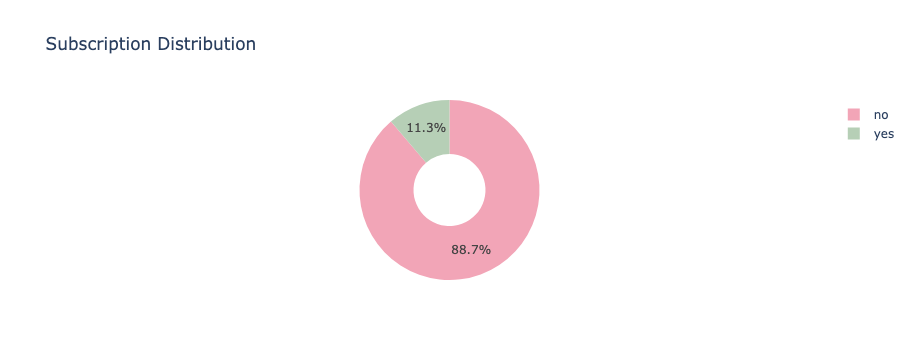

In [92]:
# Visualize subscription (target variable) distribution and observe if there is an imbalance

fig = px.pie(
    bankmktg_df,
    names='subscription',
    title='Subscription Distribution',
    hole=0.4,
    color_discrete_sequence=['#F2A5B7', '#B6CFB6'] 
)
fig.update_traces(textposition='inside', textinfo='percent')
fig.write_image("images/subscription_dist.png")
fig.show()

#### There's definitely an imbalance in the data

In [18]:
# Examine columns job, marital and education - list unique values

unique_values = {col: bankmktg_df[col].unique() for col in ['job', 'marital', 'education']}
print(unique_values)

{'job': array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object), 'marital': array(['married', 'single', 'divorced', 'unknown'], dtype=object), 'education': array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)}


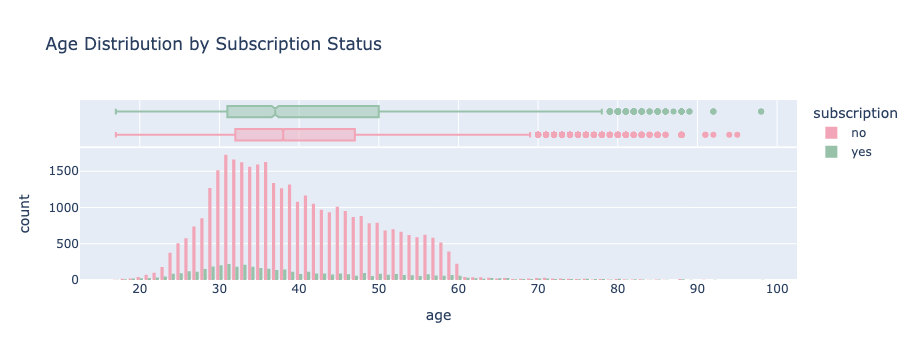

In [106]:
fig = px.histogram(
    bankmktg_df,
    x="age",
    color="subscription",     # groups by subscribed/not subscribed
    barmode="group",        # show bars side by side; use "stack" if you prefer stacked bars
    title="Age Distribution by Subscription Status",
    color_discrete_sequence=['#F2A5B7', '#97C1A9'],
    marginal='box'
)
fig.write_image("images/age.png")
fig.show()

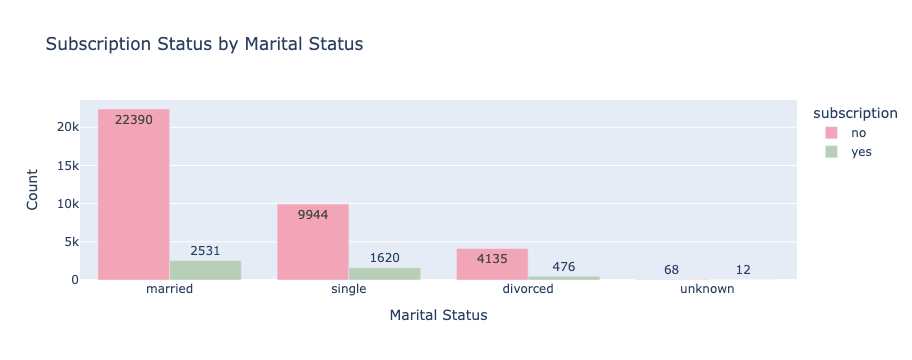

In [96]:
# Plot subscription status by marital status
marital_counts = bankmktg_df.groupby(["marital", "subscription"]).size().reset_index(name="count")

marital_order = (
    marital_counts.groupby("marital")["count"].sum()
    .sort_values(ascending=False)
    .index.tolist()
)

fig = px.bar(
    marital_counts,
    x="marital",
    y="count",
    color="subscription",
    barmode="group",  
    text="count",      # show counts on bars
    category_orders={"marital": marital_order}, 
    title="Subscription Status by Marital Status",
    color_discrete_sequence=['#F2A5B7', '#B6CFB6']    
)

# Axis labels
fig.update_layout(
    xaxis_title="Marital Status",
    yaxis_title="Count"
)

fig.write_image("images/marital.png")
fig.show()


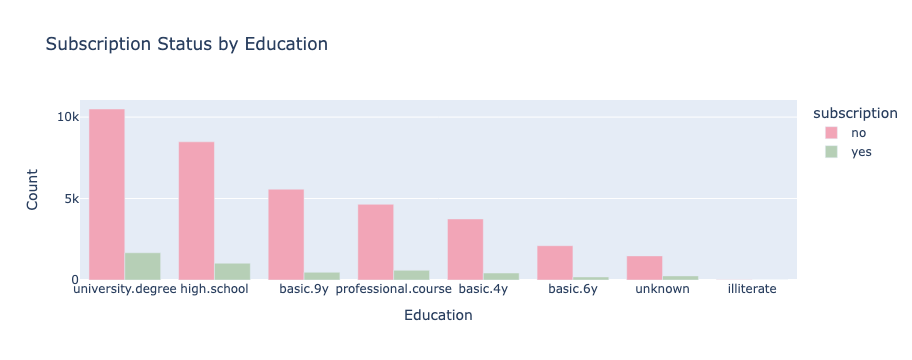

In [98]:
# Plot subscription status by education
education_counts = bankmktg_df.groupby(["education", "subscription"]).size().reset_index(name="count")

edu_order = (
    education_counts.groupby("education")["count"].sum()
    .sort_values(ascending=False)
    .index.tolist()
)

# Plotly bar chart (horizontal)
fig = px.bar(
    education_counts,
    y="count",          
    x="education",
    color="subscription",
    barmode="group",
    category_orders={"education": edu_order},   
    title="Subscription Status by Education",
    color_discrete_sequence=['#F2A5B7', '#B6CFB6'] 
)

# Axis labels
fig.update_layout(
    xaxis_title="Education",
    yaxis_title="Count"
)

fig.write_image("images/education.png")
fig.show()

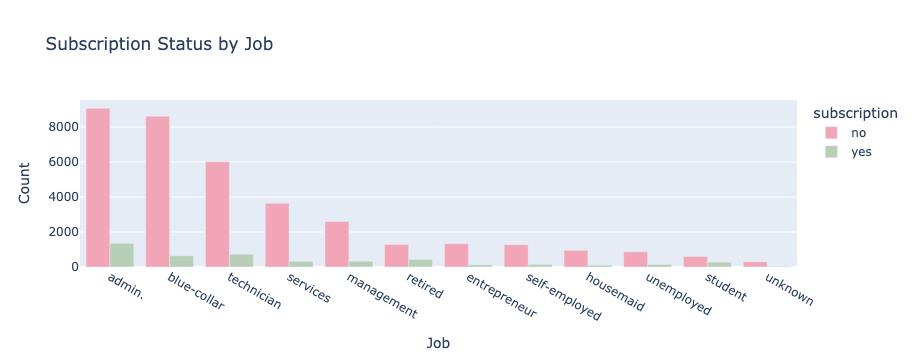

In [100]:
# Plot subscription by job

job_counts = bankmktg_df.groupby(["job", "subscription"]).size().reset_index(name="count")

job_order = (
    job_counts.groupby("job")["count"].sum()
    .sort_values(ascending=False)
    .index.tolist()
)

# Plotly bar chart 
fig = px.bar(
    job_counts,
    y="count",         
    x="job",
    color="subscription",
    barmode="group",
    category_orders={"job": job_order},   
    title="Subscription Status by Job",
    color_discrete_sequence=['#F2A5B7', '#B6CFB6'] 
)

# Axis labels
fig.update_layout(
    xaxis_title="Job",
    yaxis_title="Count"
)

fig.write_image("images/job.png")
fig.show()

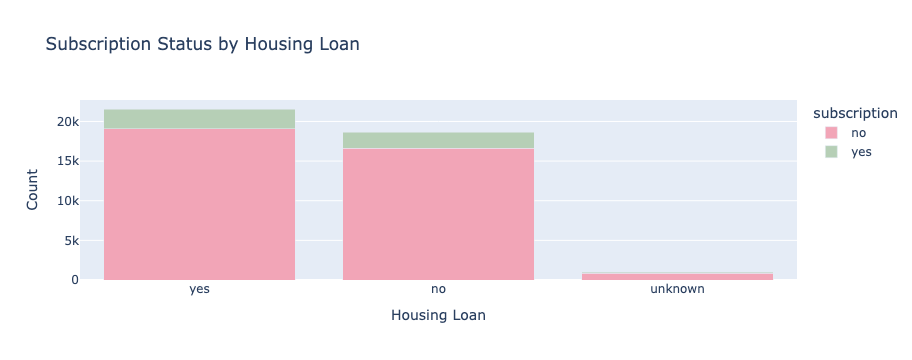

In [102]:
housing_ct = (
    bankmktg_df.groupby(["housing", "subscription"])
      .size()
      .reset_index(name="count")
)

housing_order = (
    housing_ct.groupby("housing")["count"].sum()
    .sort_values(ascending=False)
    .index.tolist()
)
# Stacked bar chart (raw counts)
fig = px.bar(
    housing_ct,
    x="housing",       # categories: yes/no housing loan
    y="count",         # raw counts
    color="subscription",   # split by subscription status
    barmode="stack",   # stack bars
    category_orders={"housing": housing_order},
    color_discrete_sequence=['#F2A5B7', '#B6CFB6'],
    title="Subscription Status by Housing Loan"
)

fig.update_layout(
    yaxis_title="Count",
    xaxis_title="Housing Loan"
)
fig.write_image("images/housing.png")
fig.show()


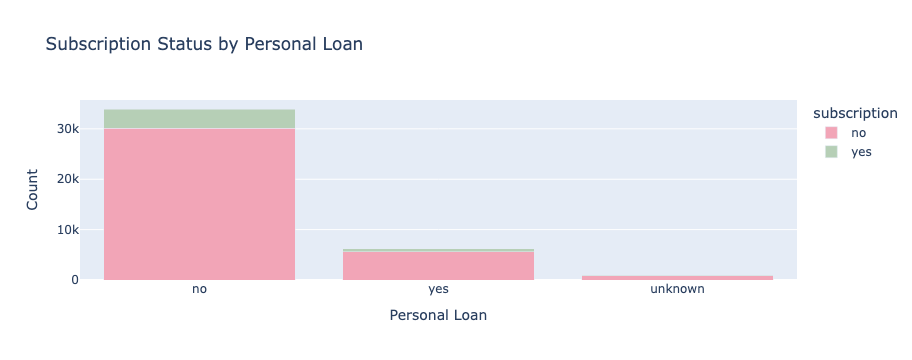

In [104]:
# Plot subscription status by clients with or without personal loan
personal_ct = (
    bankmktg_df.groupby(["loan", "subscription"])
      .size()
      .reset_index(name="count")
)

personal_order = (
    personal_ct.groupby("loan")["count"].sum()
    .sort_values(ascending=False)
    .index.tolist()
)
# Stacked bar chart (raw counts)
fig = px.bar(
    personal_ct,
    x="loan",       # categories: yes/no housing loan
    y="count",         # raw counts
    color="subscription",   # split by subscription status
    barmode="stack",   # stack bars
    category_orders={"loan": personal_order},
    color_discrete_sequence=['#F2A5B7', '#B6CFB6'],
    title="Subscription Status by Personal Loan"
)

fig.update_layout(
    yaxis_title="Count",
    xaxis_title="Personal Loan"
)
fig.write_image("images/personal_loan.png")
fig.show()


#### Clients who had no personal loans tend to subscribe more than clients who had personal loans.

In [76]:
# Counts the number of contacts performed during the campaign (i.e. there are 17,642 were contacted in the first campaign)
bankmktg_df['campaign'].value_counts()

1     17634
2     10568
3      5340
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: campaign, dtype: int64

#### In the first few campaigns(1 thru 5), there were thousands of clients contacted but slowly decreased down on the subsequent campaigns after that.

In [110]:
binary_cols = ['subscription', 'housing', 'loan']
le = LabelEncoder()
for col in binary_cols:
    bankmktg_df[col] = le.fit_transform(bankmktg_df[col])

print(bankmktg_df)

       age          job  marital            education  default  housing  loan  \
0       56    housemaid  married             basic.4y       no        0     0   
1       57     services  married          high.school  unknown        0     0   
2       37     services  married          high.school       no        2     0   
3       40       admin.  married             basic.6y       no        0     0   
4       56     services  married          high.school       no        0     2   
...    ...          ...      ...                  ...      ...      ...   ...   
41183   73      retired  married  professional.course       no        2     0   
41184   46  blue-collar  married  professional.course       no        0     0   
41185   56      retired  married    university.degree       no        2     0   
41186   44   technician  married  professional.course       no        0     0   
41187   74      retired  married  professional.course       no        2     0   

       duration  campaign  

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                        Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                        --------------  ----- 
 0   age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"  4119 non-null   object
dtypes: object(1)
memory usage: 32.3+ KB


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Problem 9: Score the Model

What is the accuracy of your model?

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions